## Import modules

In [1]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.7 MB/s eta 0:00:0000:010:01
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [2]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 14.4 MB/s eta 0:00:00 0:00:01


In [3]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization, Embedding
import tensorflow_hub as hub
import tensorflow_text as text

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import random
import datetime
import matplotlib.pyplot as plt
import io
from IPython.display import FileLink

import warnings
warnings.filterwarnings('ignore')

2024-11-10 12:25:41.387087: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-10 12:25:41.387222: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-10 12:25:41.511664: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


****

# Exploratory Data Analysis

## Import data

In [4]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df_shuffled = train_df.sample(frac=1, random_state=1)
train_df_shuffled.head()

,id,keyword,location,text,target
3228,4632,emergency%20services,"Sydney, New South Wales",Goulburn man Henry Van Bilsen missing: Emergen...,1
3706,5271,fear,NaN,The things we fear most in organizations--fluc...,0
6957,9982,tsunami,Land Of The Kings,@tsunami_esh ?? hey Esh,0
2887,4149,drown,NaN,@POTUS you until you drown by water entering t...,0
7464,10680,wounds,"cody, austin follows ?*?",Crawling in my skin\nThese wounds they will no...,1


In [6]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
train_df['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

This is a relatively balanced dataset

## Preprocessing

### Split into training and validation data

In [9]:
# Set target and predictors
X = train_df_shuffled['text'].to_numpy()
y = train_df_shuffled['target'].to_numpy()

# Split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(X, y, random_state=1, test_size=0.1)

### Text vectorization

In [10]:
# Find average number of tokens in tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [11]:
# Set custom parameters
max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_sequence_length=max_length)

# Adapt the text vectorizer to training data
text_vectorizer.adapt(train_sentences)

In [13]:
# Get unique values
vocab_words = text_vectorizer.get_vocabulary()

# Get most common and least common words
most_common = vocab_words[:5]
least_common =vocab_words[-5:]

print("Most common:", most_common)
print("Least common:", least_common)

Most common: ['', '[UNK]', 'the', 'a', 'in']
Least common: ['palmer', 'palm', 'palinfoen', 'palestinian\x89Û', 'paleface']


### Embedding

We use embedding to make the vectorized text learnable

In [14]:
# Create embedding layer
embedding = layers.Embedding(input_dim=max_vocab_length,
                            output_dim=128,
                            input_length=max_length,
                            name='embedding_1')

****

# Model Construction

In [16]:
def metrics_dict(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    metrics = {"Accuracy" : acc,
              "Precision" : prec,
              "Recall" : recall,
              "F1 Score" : f1}
    return metrics

## Model 1 | LSTM

### Build Model

In [17]:
# Build model
# - Input
inputs = layers.Input(shape=(1,), dtype=tf.string)

# - Turn text into numbers
x = text_vectorizer(inputs)
x = embedding(x)

# - Hidden Layers
x = layers.LSTM(128)(x)
x = layers.Dense(128)(x)

# - Output layers
outputs = layers.Dense(1, activation='sigmoid')(x)
model_1 = tf.keras.Model(inputs, outputs, name='model_1_lstm')

# Compile model
model_1.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])
# Fit model
history1 = model_1.fit(train_sentences, train_labels,
                      validation_data=[val_sentences, val_labels],
                      epochs=10,
                      )

Epoch 1/10


I0000 00:00:1731241558.429101     119 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


215/215 [==============================] - 11s 34ms/step - loss: 0.5024 - accuracy: 0.7503 - val_loss: 0.4722 - val_accuracy: 0.7927
Epoch 2/10
215/215 [==============================] - 2s 10ms/step - loss: 0.3041 - accuracy: 0.8745 - val_loss: 0.4944 - val_accuracy: 0.7651
Epoch 3/10
215/215 [==============================] - 1s 7ms/step - loss: 0.2051 - accuracy: 0.9256 - val_loss: 0.6705 - val_accuracy: 0.7533
Epoch 4/10
215/215 [==============================] - 2s 9ms/step - loss: 0.1370 - accuracy: 0.9512 - val_loss: 0.7151 - val_accuracy: 0.7585
Epoch 5/10
215/215 [==============================] - 2s 7ms/step - loss: 0.0986 - accuracy: 0.9620 - val_loss: 0.9400 - val_accuracy: 0.7415
Epoch 6/10
215/215 [==============================] - 1s 7ms/step - loss: 0.0699 - accuracy: 0.9720 - val_loss: 1.5274 - val_accuracy: 0.7375
Epoch 7/10
215/215 [==============================] - 1s 6ms/step - loss: 0.0598 - accuracy: 0.9730 - val_loss: 1.3964 - val_accuracy: 0.7533
Epoch 8/10
215

In [18]:
model_1.summary()

Model: "model_1_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                      

### Evaluate Model

In [19]:
# Get predictions
model_1_pred_probs = model_1.predict(val_sentences)
model_1_preds = tf.squeeze(tf.round((model_1_pred_probs)))

# Compute metrics
model_1_metrics = metrics_dict(val_labels, model_1_preds)
model_1_metrics

24/24 [==============================] - 0s 3ms/step


{'Accuracy': 0.7480314960629921,
 'Precision': 0.6993464052287581,
 'Recall': 0.6815286624203821,
 'F1 Score': 0.7475207976964626}

(0.0, 1.0)

<Figure size 640x480 with 0 Axes>

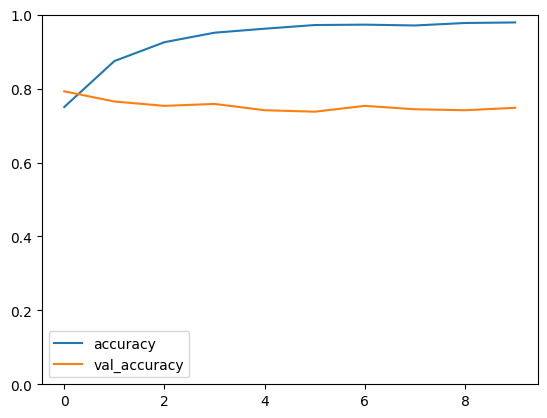

In [20]:
# Plot accuracy curves
history1_plot = pd.DataFrame(history1.history)

plt.figure()
history1_plot.loc[ : , ['accuracy', 'val_accuracy']].plot()
plt.ylim(0,1)

Still some overfitting

## Modified LSTM

In [21]:
import tensorflow as tf
from tensorflow.keras import layers

# Input layer
inputs = layers.Input(shape=(1,), dtype=tf.string)

# Text vectorization and embedding layers
x = text_vectorizer(inputs)
x = embedding(x)

# Single LSTM layer with lighter dropout
x = layers.LSTM(128)(x)
x = layers.Dropout(0.2)(x)  # Reduced dropout rate

# Smaller dense layer
x = layers.Dense(64, activation='relu')(x)

# Output layer
outputs = layers.Dense(1, activation='sigmoid')(x)

# Model definition
model_2 = tf.keras.Model(inputs, outputs, name='simplified_lstm_model_2')

# Compile model
model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                metrics=['accuracy'])

# EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit model with EarlyStopping
history2 = model_2.fit(train_sentences, train_labels,
                       validation_data=(val_sentences, val_labels),
                       epochs=10,
                       callbacks=[early_stopping])


Epoch 1/10
215/215 [==============================] - 11s 34ms/step - loss: 0.1679 - accuracy: 0.9508 - val_loss: 0.9576 - val_accuracy: 0.7612
Epoch 2/10
215/215 [==============================] - 2s 11ms/step - loss: 0.0524 - accuracy: 0.9781 - val_loss: 1.5068 - val_accuracy: 0.7388
Epoch 3/10
215/215 [==============================] - 2s 7ms/step - loss: 0.0420 - accuracy: 0.9812 - val_loss: 1.6268 - val_accuracy: 0.7690
Epoch 4/10
215/215 [==============================] - 2s 8ms/step - loss: 0.0374 - accuracy: 0.9822 - val_loss: 1.7230 - val_accuracy: 0.7559


In [22]:
# Get predictions
model_2_pred_probs = model_2.predict(val_sentences)
model_2_preds = tf.squeeze(tf.round((model_2_pred_probs)))

# Compute metrics
model_2_metrics = metrics_dict(val_labels, model_2_preds)
model_2_metrics

24/24 [==============================] - 0s 3ms/step


{'Accuracy': 0.7611548556430446,
 'Precision': 0.746268656716418,
 'Recall': 0.6369426751592356,
 'F1 Score': 0.7575476336848006}

## Model 3 | GRU-Cell Powered RNN¶


Build Model¶


In [23]:

inputs = layers.Input(shape=(1,), dtype=tf.string)

# - Turn text into numbers
x = text_vectorizer(inputs)
x = embedding(x)

# - Hidden layers
x = layers.GRU(128)(x)
x = layers.Dense(128)(x)

# - Output layers
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_gru')

# Compile model
model_3.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

# Fit model
history3 = model_3.fit(train_sentences, train_labels,
                      validation_data=[val_sentences, val_labels],
                      epochs = 10)

Epoch 1/10
215/215 [==============================] - 10s 35ms/step - loss: 0.1510 - accuracy: 0.9473 - val_loss: 0.8309 - val_accuracy: 0.7546
Epoch 2/10
215/215 [==============================] - 2s 9ms/step - loss: 0.0682 - accuracy: 0.9769 - val_loss: 0.9703 - val_accuracy: 0.7493
Epoch 3/10
215/215 [==============================] - 2s 7ms/step - loss: 0.0488 - accuracy: 0.9785 - val_loss: 1.4127 - val_accuracy: 0.7375
Epoch 4/10
215/215 [==============================] - 2s 7ms/step - loss: 0.0456 - accuracy: 0.9778 - val_loss: 1.7880 - val_accuracy: 0.7454
Epoch 5/10
215/215 [==============================] - 2s 8ms/step - loss: 0.0455 - accuracy: 0.9774 - val_loss: 1.4165 - val_accuracy: 0.7467
Epoch 6/10
215/215 [==============================] - 1s 7ms/step - loss: 0.0402 - accuracy: 0.9797 - val_loss: 1.8233 - val_accuracy: 0.7402
Epoch 7/10
215/215 [==============================] - 1s 6ms/step - loss: 0.0405 - accuracy: 0.9803 - val_loss: 1.9197 - val_accuracy: 0.7283
Epoc

In [24]:
model_3.summary()


Model: "model_3_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 128)               99072     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                       

In [25]:
# Get predictions
model_3_pred_probs = model_3.predict(val_sentences)
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))

# Get metrics
model_3_metrics = metrics_dict(val_labels, model_3_preds)
model_3_metrics

24/24 [==============================] - 0s 3ms/step


{'Accuracy': 0.7454068241469817,
 'Precision': 0.696078431372549,
 'Recall': 0.678343949044586,
 'F1 Score': 0.7448908060058007}

(0.0, 1.0)

<Figure size 640x480 with 0 Axes>

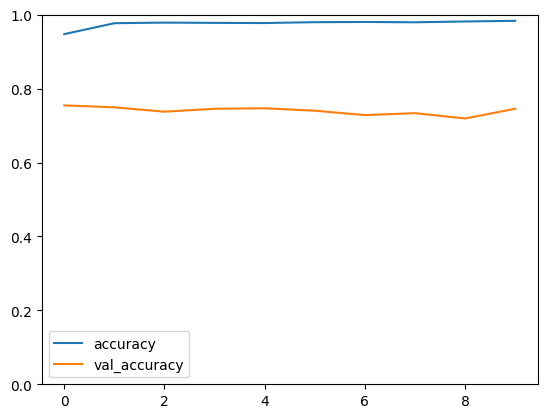

In [26]:
# Plot accuracy curves
history3_plot = pd.DataFrame(history3.history)

plt.figure()
history3_plot.loc[ : , ['accuracy', 'val_accuracy']].plot()
plt.ylim(0, 1)

LSTM is better 

#### Model 4 | Convolutional Neural Network

### Build Model

In [27]:
# Build model
# - Input layer
inputs = tf.keras.Input(shape=(1,), dtype=tf.string)

# - Turn text into numbers
x = text_vectorizer(inputs)
x = embedding(x)

# - Hidden layers
x = layers.Conv1D(10, 3, activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)

# - Output layer
outputs = layers.Dense(1, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name='model_5_cnn')

# Compile model
model_4.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

# Fit model
history5 = model_4.fit(train_sentences, train_labels,
                      validation_data=[val_sentences, val_labels],
                      epochs=10)

Epoch 1/10
215/215 [==============================] - 9s 32ms/step - loss: 0.3463 - accuracy: 0.8818 - val_loss: 0.5508 - val_accuracy: 0.7795
Epoch 2/10
215/215 [==============================] - 2s 9ms/step - loss: 0.1531 - accuracy: 0.9492 - val_loss: 0.6862 - val_accuracy: 0.7480
Epoch 3/10
215/215 [==============================] - 2s 7ms/step - loss: 0.1067 - accuracy: 0.9620 - val_loss: 0.8125 - val_accuracy: 0.7283
Epoch 4/10
215/215 [==============================] - 1s 5ms/step - loss: 0.0828 - accuracy: 0.9712 - val_loss: 0.9403 - val_accuracy: 0.7638
Epoch 5/10
215/215 [==============================] - 1s 7ms/step - loss: 0.0702 - accuracy: 0.9737 - val_loss: 1.0342 - val_accuracy: 0.7428
Epoch 6/10
215/215 [==============================] - 1s 5ms/step - loss: 0.0625 - accuracy: 0.9759 - val_loss: 1.1064 - val_accuracy: 0.7297
Epoch 7/10
215/215 [==============================] - 1s 5ms/step - loss: 0.0561 - accuracy: 0.9761 - val_loss: 1.1766 - val_accuracy: 0.7336
Epoch

### Evaluate Model

In [28]:
# Get predictions
model_4_pred_probs = model_5.predict(val_sentences)
model_4_preds = tf.squeeze(tf.round(model_5_pred_probs))

# Get metrics
model_4_metrics = metrics_dict(val_labels, model_5_preds)
model_4_metrics

24/24 [==============================] - 0s 2ms/step


{'Accuracy': 0.7427821522309711,
 'Precision': 0.6928104575163399,
 'Recall': 0.6751592356687898,
 'F1 Score': 0.7422608143151389}

(0.0, 1.0)

<Figure size 640x480 with 0 Axes>

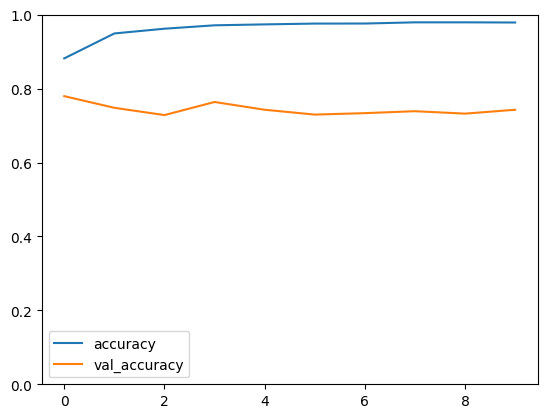

In [29]:
# Plot accuracy curves
history4_plot = pd.DataFrame(history4.history)

plt.figure()
history4_plot.loc[: , ['accuracy', 'val_accuracy']].plot()
plt.ylim(0,1)

## Model 5 | USE Feature Extractor


In [30]:
use_embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2")
use_embed_samples = use_embed(["When you use the universal encoder on a sentence, it turns it into numbers."])
use_embed_samples[0][:50]

Attaching 'None' from model 'google/universal-sentence-encoder/tensorflow2/universal-sentence-encoder/2' to your Kaggle notebook...


<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([ 0.02248132, -0.08949932, -0.01029222, -0.00759967,  0.01276698,
       -0.07062869, -0.06677138,  0.002157  ,  0.04718045,  0.08474232,
       -0.03809095, -0.03091419,  0.0262356 ,  0.07135751,  0.06256958,
        0.0022553 ,  0.02755551, -0.05867719, -0.01160263,  0.05465815,
        0.01581767,  0.01556384,  0.04033248,  0.05218771, -0.07685868,
        0.06601251, -0.02816208, -0.0068457 , -0.00036916,  0.06069897,
        0.02800913,  0.02646722, -0.01382347, -0.03609171, -0.10304508,
       -0.0189616 ,  0.01086119,  0.06148282,  0.01016747, -0.00619409,
       -0.00328086, -0.01699765,  0.04171558, -0.02337643,  0.03311281,
        0.0125403 , -0.05408401, -0.06566298,  0.01324988, -0.01107215],
      dtype=float32)>

Build Model

In [31]:
# Build encoding layer
use_encoder_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
                                  input_shape=[],
                                  dtype=tf.string,
                                  trainable=False,
                                  name="USE")

Attaching 'None' from model 'google/universal-sentence-encoder/tensorflow2/universal-sentence-encoder/2' to your Kaggle notebook...


In [32]:
# Build model
model_6 = tf.keras.Sequential([
    # Encoding
    use_encoder_layer,
    layers.Dense(64, activation='relu'),
    
    # Decoding
    layers.Dense(1, activation='sigmoid')
], name="model_6_use")

# Compile model
model_6.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

# Fit model
history6 = model_6.fit(train_sentences, train_labels,
                      validation_data=[val_sentences, val_labels],
                      epochs=10)

Epoch 1/10
215/215 [==============================] - 5s 12ms/step - loss: 0.5038 - accuracy: 0.7832 - val_loss: 0.4608 - val_accuracy: 0.7913
Epoch 2/10
215/215 [==============================] - 2s 10ms/step - loss: 0.4123 - accuracy: 0.8142 - val_loss: 0.4597 - val_accuracy: 0.7900
Epoch 3/10
215/215 [==============================] - 2s 10ms/step - loss: 0.3987 - accuracy: 0.8231 - val_loss: 0.4580 - val_accuracy: 0.7953
Epoch 4/10
215/215 [==============================] - 2s 10ms/step - loss: 0.3897 - accuracy: 0.8307 - val_loss: 0.4605 - val_accuracy: 0.7940
Epoch 5/10
215/215 [==============================] - 2s 10ms/step - loss: 0.3831 - accuracy: 0.8329 - val_loss: 0.4657 - val_accuracy: 0.7913
Epoch 6/10
215/215 [==============================] - 2s 10ms/step - loss: 0.3776 - accuracy: 0.8362 - val_loss: 0.4628 - val_accuracy: 0.7992
Epoch 7/10
215/215 [==============================] - 2s 10ms/step - loss: 0.3722 - accuracy: 0.8375 - val_loss: 0.4647 - val_accuracy: 0.8005

In [33]:
model_6.summary()

Model: "model_6_use"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [34]:
# Get predictions
model_6_pred_probs = model_6.predict(val_sentences)
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))

# Get metrics
model_6_metrics = metrics_dict(val_labels, model_6_preds)
model_6_metrics

24/24 [==============================] - 1s 8ms/step


{'Accuracy': 0.7992125984251969,
 'Precision': 0.7766323024054983,
 'Recall': 0.7197452229299363,
 'F1 Score': 0.7979085519731843}

(0.0, 1.0)

<Figure size 640x480 with 0 Axes>

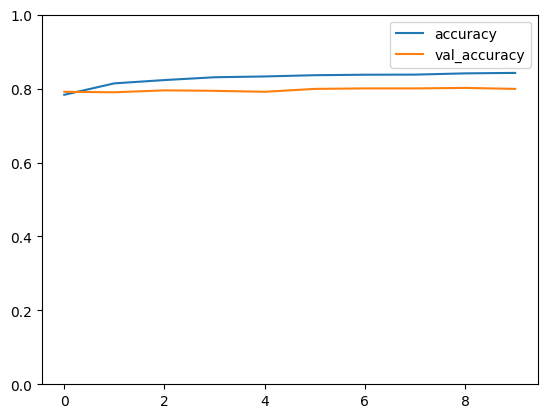

In [35]:
# Plot accuracy curves
history6_plot = pd.DataFrame(history6.history)

plt.figure()
history6_plot.loc[ : ,['accuracy', 'val_accuracy']].plot()
plt.ylim(0, 1)

## Model 7 | BERT 

### Preprocessing layer 

In [36]:
# Load BERT from TensorFlow Hub
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3", trainable=True)

# Define BERT-based model
def build_bert_model():
    # Input layer
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
    
    # BERT preprocessing
    preprocessed_text = bert_preprocess(text_input)
    
    # BERT encoder
    outputs = bert_encoder(preprocessed_text)
    pooled_output = outputs["pooled_output"]  # [batch_size, 768]
    
    # Dense layer(s) for classification
    dropout = tf.keras.layers.Dropout(0.3)(pooled_output)
    output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(dropout)
    
    # Define the model
    model = tf.keras.Model(inputs=text_input, outputs=output, name="BERT_model")
    return model

# Instantiate the model
bert_model = build_bert_model()

# Compile the model
bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
                   loss="binary_crossentropy",
                   metrics=["accuracy"])

# Show the model summary
bert_model.summary()


Model: "BERT_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                         

In [37]:
# Set batch size and epochs
batch_size = 32
epochs = 3

# Train the model
history = bert_model.fit(train_sentences, train_labels,
                         validation_data=(val_sentences, val_labels),
                         epochs=epochs,
                         batch_size=batch_size)


Epoch 1/3
215/215 [==============================] - 239s 935ms/step - loss: 0.4371 - accuracy: 0.8066 - val_loss: 0.4124 - val_accuracy: 0.8189
Epoch 2/3
215/215 [==============================] - 200s 932ms/step - loss: 0.3106 - accuracy: 0.8841 - val_loss: 0.5367 - val_accuracy: 0.7743
Epoch 3/3
215/215 [==============================] - 200s 933ms/step - loss: 0.2113 - accuracy: 0.9254 - val_loss: 0.5300 - val_accuracy: 0.7979


In [38]:
# Predict on validation data
val_predictions = (bert_model.predict(val_sentences) > 0.5).astype(int).flatten()

# Calculate metrics
results = metrics_dict(val_labels, val_predictions)
print("Validation Results:", results)


24/24 [==============================] - 8s 334ms/step
Validation Results: {'Accuracy': 0.7979002624671916, 'Precision': 0.7439024390243902, 'Recall': 0.7770700636942676, 'F1 Score': 0.7984998759890217}


(0.0, 1.0)

<Figure size 640x480 with 0 Axes>

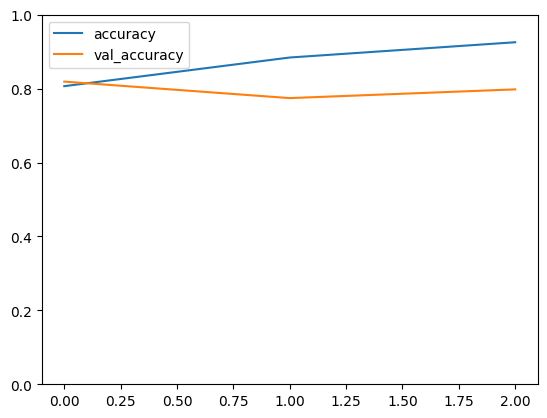

In [39]:
history_plot = pd.DataFrame(history.history)
plt.figure()
history_plot.loc[ : , ['accuracy', 'val_accuracy']].plot()
plt.ylim(0,1)

## Modified BERT

In [40]:
def build_modified_bert_model():
    # Input layer for raw text
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
    
    # Preprocess the text for BERT
    preprocessed_text = bert_preprocess(text_input)
    
    # Pass the preprocessed text to the BERT encoder
    bert_output = bert_encoder(preprocessed_text)
    pooled_output = bert_output["pooled_output"]  
    
    # Add a dense layer with ReLU activation
    dense1 = tf.keras.layers.Dense(256, activation="relu")(pooled_output)
    dropout1 = tf.keras.layers.Dropout(0.3)(dense1)
    
    # Add another dense layer with ReLU activation
    dense2 = tf.keras.layers.Dense(128, activation="relu")(dropout1)
    dropout2 = tf.keras.layers.Dropout(0.3)(dense2)
    
    # Output layer with sigmoid for binary classification
    output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(dropout2)
    
    # Define the modified model
    model = tf.keras.Model(inputs=text_input, outputs=output, name="Modified_BERT_model")
    return model

# Instantiate the modified BERT model
modified_bert_model = build_modified_bert_model()

# Compile the model
modified_bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                            loss="binary_crossentropy",
                            metrics=["accuracy"])

# Show model summary
modified_bert_model.summary()


Model: "Modified_BERT_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                

In [41]:
# Train the modified BERT model
history = modified_bert_model.fit(train_sentences, train_labels,
                                  validation_data=(val_sentences, val_labels),
                                  epochs=2,
                                  batch_size=32)

# Predictions
val_predictions = (modified_bert_model.predict(val_sentences) > 0.5).astype(int).flatten()

# Evaluate the model
results = metrics_dict(val_labels, val_predictions)
print("Modified BERT Validation Results:", results)


Epoch 1/2
215/215 [==============================] - 230s 939ms/step - loss: 0.1689 - accuracy: 0.9447 - val_loss: 0.6726 - val_accuracy: 0.7940
Epoch 2/2
24/24 [==============================] - 8s 334ms/step
Modified BERT Validation Results: {'Accuracy': 0.8110236220472441, 'Precision': 0.7931034482758621, 'Recall': 0.732484076433121, 'F1 Score': 0.8097340337496683}


(0.0, 1.0)

<Figure size 640x480 with 0 Axes>

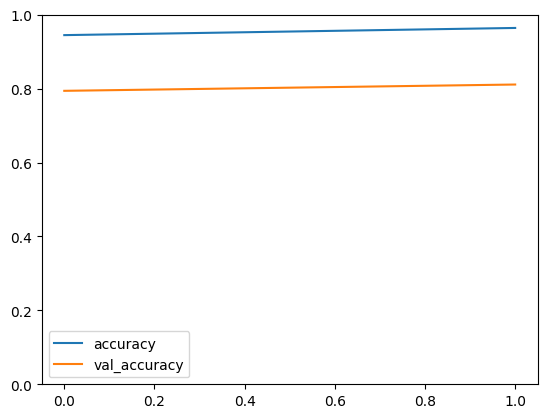

In [42]:
history_plot = pd.DataFrame(history.history)
plt.figure()
history_plot.loc[ : , ['accuracy', 'val_accuracy']].plot()
plt.ylim(0,1)